# Mixed-dimensional problem

A strength of Dune-MMesh is its application to mixed-dimensional problems.
So, let us consider a mixed-dimensional Burger's equation on a domain with a lower-dimensional interface $\Gamma$ that represents a physical domain with aperture $d > 0$.

Find $u, u_\Gamma$ s.t
\begin{align}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
u_t + \operatorname{div} \mathbf{F}(u) &= 0, &&\quad \text{in } \Omega, \\
(d u_\Gamma)_t + \operatorname{div} c \mathbf{F}(u_\Gamma) &= \jump{\mathbf{F}(u) \cdot \mathbf{n}}, &&\quad \text{in } \Gamma,
\end{align}
where $\mathbf{F}(u) = \frac{1}{2} u^2 \mathbf{a}$ with $\mathbf{a} = [1,0]^T$ and $c > 0$ is a speed scaling for the interface problem.

We impose the interior boundary condition for the bulk problem
\begin{align}
F(u) &= F(u_\Gamma), \quad \text{on } \Gamma, \\
\end{align}
and consider inflow from left on the [T-junction](grids/tjunction.rst) grid.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

file = "grids/tjunction.msh"

gridView = mmesh((reader.gmsh, file), 2)
igridView = gridView.hierarchicalGrid.interfaceGrid

In [2]:
from ufl import *
from dune.ufl import Constant

d = Constant(0.01, name="d")
a = as_vector([1, 0])
c = Constant(100, name="c")

def F(u):
    return 0.5 * u**2 * a

def upwind(u_l, u_r, n):
    return inner( conditional( inner(a, n) > 0, F(u_l), F(u_r) ), n )

dt = 0.25
tau = Constant(dt, name="tau")

## Bulk problem

We use a finite volume space and define the UFL form of the bulk problem. Hereby, we used the interface indicator `I` to distinguish between interface and non-interface facets.

In [3]:
from dune.fem.space import finiteVolume
space = finiteVolume(gridView)

u  = TrialFunction(space)
uu = TestFunction(space)

x = SpatialCoordinate(space)
n = FacetNormal(space)

left = conditional(x[0] < 1e-6, 1, 0)
uD = 1

uh = space.interpolate(0, name="uh")
uhOld = uh.copy()

from dune.mmesh import interfaceIndicator
I = interfaceIndicator(igridView)

A  = (u - uhOld) * uu * dx
A += tau * upwind(u('+'), u('-'), n('+')) * jump(uu) * (1-I)*dS
A += tau * upwind(u, uD, n) * uu * left * ds

## Interface problem

Similarly, we define the UFL form of the interface problem.

In [4]:
ispace = finiteVolume(igridView)

u_g  = TrialFunction(ispace)
uu_g = TestFunction(ispace)

n_g = FacetNormal(ispace)

uh_g = ispace.interpolate(0, name="uh_g")
uhOld_g = uh_g.copy()

A_g  = d * (u_g - uhOld_g) * uu_g * dx
A_g += tau * c * upwind(u_g('+'), u_g('-'), n_g('+')) * jump(uu_g) * dS

## Coupling condition

The coupling condition can be incorporated using the trace and skeleton functionality.

In [5]:
from dune.mmesh import skeleton, trace, normals

u_gamma = avg(skeleton(uh_g))

A += tau * upwind(u('+'), u_gamma, n('+')) * uu('+') * I*dS
A += tau * upwind(u('-'), u_gamma, n('-')) * uu('-') * I*dS


traceu = trace(uh)
inormal = normals(igridView)

A_g -= tau * upwind(traceu('+'), u_g, -inormal) * uu_g * dx
A_g -= tau * upwind(traceu('-'), u_g, -inormal) * uu_g * dx

## Monolithic solution strategy

Dune-MMesh provides coupled solution strategies to solve bulk and interface schemes together, either iteratively or monolithically. Here, we choose the monolithicSolve method that implements a mixed-dimensional Newton method.

In [6]:
from dune.fem.scheme import galerkin
scheme   = galerkin([A   == 0])
scheme_g = galerkin([A_g == 0])

from dune.mmesh import monolithicSolve
def solve():
    uhOld.assign(uh)
    uhOld_g.assign(uh_g)
    monolithicSolve(schemes=(scheme, scheme_g), targets=(uh, uh_g), verbose=False)

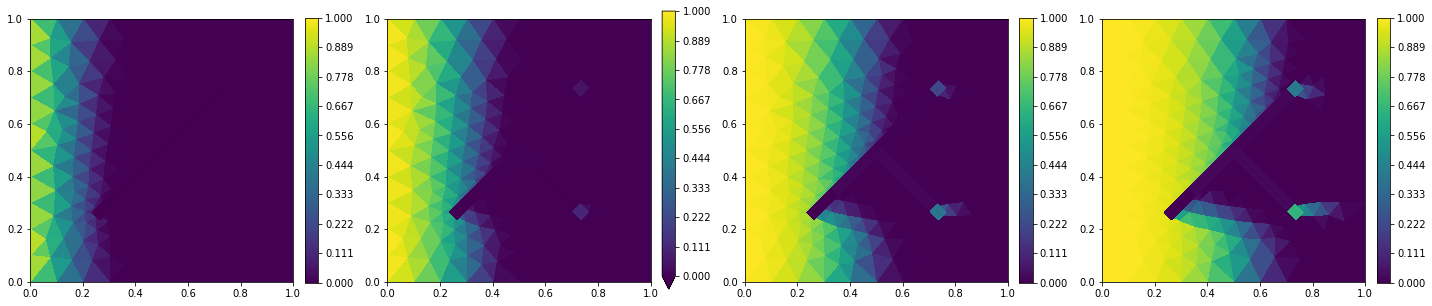

In [7]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

fig, axs = plt.subplots(1, 4, figsize=(20,5))

for i in range(4):
    solve()

    plot(uh, figure=(fig, axs[i]), gridLines=None, clim=[0,1])
    plot(uh_g, figure=(fig, axs[i]), linewidth=0.04, clim=[0,1], colorbar=None)